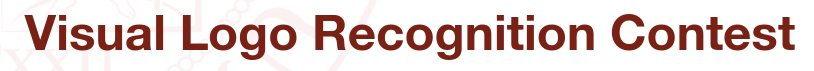

VISION AND COGNITIVE SYSTEMS A.Y. 2022/2023

The aim of the contest is to retrieve the most similar images representing logos of famous companies from a database set containing 110 images. We will consider 4 query images and use the SIFT algorithm. Model performance will be evaluated using average precision (AP) and mean average precision (mAP) metrics.
You can modify the baseline (parameters, feature matching technique, ...) and then submit your results.

- [Submit results](https://forms.gle/mNjZNVjuDuDkffBB6)
- [Visualize Submissions](https://bit.ly/3EZbYSn)

In [ ]:
%%capture
# Update OpenCV package
!pip install -U opencv-python
!pip install opencv-contrib-python

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/VS/'

Mounted at /content/drive


In [ ]:
# Upload the zip folders (query.zip and database.zip)
%%capture
!unzip query.zip
!unzip database.zip

In [ ]:
ls

drive/  sample_data/


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# List of query/database images
query_images = []
db_images = []
logo_names = []

# Resize images
img_size = (400, 400)

# Read query images
# Order by name
query_dir = sorted(os.listdir('{}query/'.format(data_dir)))
for idx, img_name in enumerate(query_dir):
  # Read image
  img = cv2.imread(os.path.join('{}query/'.format(data_dir), img_name))
  # Resize image
  img = cv2.resize(img, dsize=img_size)
  # Save image
  query_images.append(img)
  # Save logo names (remove "_logo.txt" and capitalize)
  logo_names.append(os.path.splitext(img_name)[0][:-5].capitalize())
  #print("Image '" + img_name + "' loaded.")
print("Query images loaded!")

# Read db images
# Order by number
db_dir = sorted(os.listdir('{}database/'.format(data_dir)), key=lambda x: int(x.split('.')[0]))
for idx, img_name in enumerate(db_dir):
  # Read image
  img = cv2.imread(os.path.join('{}database/'.format(data_dir), img_name))
  # Resize image
  img = cv2.resize(img, dsize=img_size)
  # Save image
  db_images.append(img)
  #print("Image '" + img_name + "' loaded.")
print("Database images loaded!")

Query images loaded!
Database images loaded!


In [ ]:
# Plot query images
fig = plt.figure(figsize=(12,12))
for i in range(len(query_images)):
  _ = plt.subplot(1, len(query_images), i+1), plt.title("Query image n. " + str(i))
  plt.imshow(cv2.cvtColor(query_images[i], cv2.COLOR_BGR2RGB)), plt.axis('off')

# Plot database images
fig = plt.figure(figsize=(12, 80))
for i in range(len(db_images)):
  _ = plt.subplot(int(len(db_images)/5), 5, i+1), plt.title("DB image n. " + str(i))
  plt.imshow(cv2.cvtColor(db_images[i], cv2.COLOR_BGR2RGB)), plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Ground-truth arrays per logo
coca_cola_GT = np.zeros(len(db_images))
marlboro_GT = np.zeros(len(db_images))
starbucks_GT = np.zeros(len(db_images))
heineken_GT = np.zeros(len(db_images))

coca_cola_GT[18:25] = 1
marlboro_GT[55:61] = 1
marlboro_GT[100:] = 1
starbucks_GT[70:100] = 1
heineken_GT[25:55] = 1

# Matrix containing ground-truth values for each query image
GT_matrix = np.vstack([coca_cola_GT, heineken_GT, marlboro_GT, starbucks_GT])
print(f"GT matrix shape: {GT_matrix.shape}")

n_coca_cola = int(coca_cola_GT.sum())
n_heineken = int(heineken_GT.sum())
n_marlboro = int(marlboro_GT.sum())
n_starbucks = int(starbucks_GT.sum())
n_others = len(db_images) - (n_coca_cola + n_heineken + n_marlboro + n_starbucks)
print(f"Number of database images (coca_cola): {n_coca_cola}")
print(f"Number of database images (heineken): {n_heineken}")
print(f"Number of database images (marlboro): {n_marlboro}")
print(f"Number of database images (starbucks): {n_starbucks}")
print(f"Number of database images (others): {n_others}")
# print(GT_matrix)

GT matrix shape: (4, 110)
Number of database images (coca_cola): 7
Number of database images (heineken): 30
Number of database images (marlboro): 16
Number of database images (starbucks): 30
Number of database images (others): 27


In [ ]:
# Just for SIFT
def detect_and_compute(images, detector, descriptor):
    kps = []
    des = []
    for img in images:
        kp, de = detector.detectAndCompute(img, None)
        kps.append(kp)
        des.append(de)
    return kps, des

In [ ]:
def evaluate_on_dataset(detector_method,detector,descriptor_method,descriptor, query_images, db_images, GT_matrix, ratio_thresh, matcher):



    flann = matcher

    # Calculate the keypoints and descriptors
    query_kps, query_des = detect_and_compute(query_images, detector, descriptor)
    db_kps, db_des = detect_and_compute(db_images, detector, descriptor)


    # Matrix containing the number of inlier matches per logo after RANSAC
    num_matches = np.zeros((len(query_images), len(db_images)))

    # Save matches for each descriptor of query images
    logo_matches = []  # List of lists


    # For each query image
    for q in range(len(query_images)):
        q_matches = []
        # For each database image
        for db in range(len(db_images)):

          # Find two nearest neighbours for each descriptor using FLANN
          matches = flann.knnMatch(query_des[q], db_des[db], k=2)


          # Apply ratio test
          n_matches = 0
          sel_matches = []
          for m,n in matches:
            # m is best match, n is second best match
            # Check if best match is significantly better than second match
            if m.distance < ratio_thresh * n.distance:
              n_matches += 1
              sel_matches.append(m)
          # Save number of matches
          num_matches[q, db] = n_matches
          # Save matches
          q_matches.append(sel_matches)
        logo_matches.append(q_matches)


    # Average precision calculation remains the same
    AP_all = np.zeros(len(query_images))

    for i in range(len(query_images)):
        idx = np.argsort(-num_matches[i])
        TP = GT_matrix[i, idx] == 1
        FP = GT_matrix[i, idx] == 0
        TP = np.cumsum(TP)
        FP = np.cumsum(FP)
        prec = TP / (TP + FP)
        rec = TP / np.sum(GT_matrix[i])

        AP = 0
        interp_prec = []
        for t in np.linspace(0, 1, num=11):
            p = prec[rec >= t]
            if p.size == 0:
                p = 0
            else:
                p = p.max()
            interp_prec.append(p)
            AP = AP + p/11
        AP_all[i] = AP

    mAP = np.mean(AP_all)

    print("Average Precision (AP):\n")
    for i in range(len(query_images)):
        print(f'{logo_names[i]:9s}  ===>' + ' ' * 2 + f'{AP_all[i]:.3f}')

    return mAP




In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [ ]:
cv2.SIFT_create?

In [ ]:
import optuna



class Optimization:
  def __init__(self, query_images, db_images, GT_matrix):
    self.query_images = query_images
    self.db_images = db_images
    self.GT_matrix = GT_matrix
  def objective(self, trial):


    # DETECTORS
    possible_detectors = ['SIFT']
    detector_method = trial.suggest_categorical('detector', possible_detectors)

    if detector_method == 'SIFT':


      # Define the parameters
      sift_contrast = trial.suggest_float('contrast_threshold', 0.01, 0.05)
      sift_edge = trial.suggest_float('edge_threshold', 4,12)
      sift_sigma = trial.suggest_float('sigma', 1.2, 1.8)
      sift_octave_layers = trial.suggest_int('n_octave_layers', 14,22)
      # Define the SIFT detector
      detector = cv2.SIFT_create(
            contrastThreshold=sift_contrast,
            edgeThreshold=sift_edge,
            sigma=sift_sigma,
            nOctaveLayers=sift_octave_layers,
            )

      # FLANN PARAMETERS
      # KD-tree parameters
      # In general : higher numbers take more time, but higher accuracies : therefore we set high ranges
      n_trees = trial.suggest_int('flann_trees', 8, 32) # Number of parallel kd-trees
      n_checks = trial.suggest_int('flann_checks', 50, 500)  # Number of times the trees should be recursively traversed


      # Create FLANN matcher with optimized parameters
      FLANN_INDEX_KDTREE = 1
      index_params = dict(
          algorithm=FLANN_INDEX_KDTREE,
          trees=n_trees
      )
      search_params = dict(
          checks=n_checks
      )
      matcher = cv2.FlannBasedMatcher(index_params, search_params)



    if detector_method == 'SIFT':
      descriptor = cv2.SIFT_create()


    descriptor_method = detector_method


    ratio_thresh = trial.suggest_float('ratio_threshold', 0.75, 0.95)



    mAP = evaluate_on_dataset(detector_method, detector, descriptor_method, descriptor,
                              self.query_images, self.db_images, self.GT_matrix, ratio_thresh, matcher)





    return mAP


In [ ]:
optimizer = Optimization(query_images, db_images, GT_matrix)
study = optuna.create_study(direction='maximize')
study.optimize(optimizer.objective, n_trials=500)

# Print best trial information
print("\nBest trial:")
trial = study.best_trial
print(f"  Value (mAP): {trial.value:.4f}")
print("\n  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-15 09:28:48,868] A new study created in memory with name: no-name-27809c8a-b1f5-4835-a1b7-84ed95b1f953
[I 2024-11-15 09:32:05,450] Trial 0 finished with value: 0.8150454489671166 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04328424056057626, 'edge_threshold': 10.727113281512775, 'sigma': 1.530422746387804, 'n_octave_layers': 16, 'nfeatures': 2065, 'flann_trees': 24, 'flann_checks': 247, 'ratio_threshold': 0.8102895248400803}. Best is trial 0 with value: 0.8150454489671166.


Average Precision (AP):

Cocacola   ===>  0.640
Heineken   ===>  0.880
Marlboro   ===>  0.817
Starbucks  ===>  0.923


[I 2024-11-15 09:36:20,666] Trial 1 finished with value: 0.8266100876487322 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0248528797128165, 'edge_threshold': 10.720889281839863, 'sigma': 1.3902334746610312, 'n_octave_layers': 14, 'nfeatures': 8135, 'flann_trees': 23, 'flann_checks': 249, 'ratio_threshold': 0.9413898254665176}. Best is trial 1 with value: 0.8266100876487322.


Average Precision (AP):

Cocacola   ===>  0.714
Heineken   ===>  0.842
Marlboro   ===>  0.793
Starbucks  ===>  0.957


[I 2024-11-15 09:39:04,703] Trial 2 finished with value: 0.8301626754264297 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.02155734987401769, 'edge_threshold': 5.286309815915359, 'sigma': 1.2646948455121214, 'n_octave_layers': 17, 'nfeatures': 3041, 'flann_trees': 19, 'flann_checks': 150, 'ratio_threshold': 0.8869918277346608}. Best is trial 2 with value: 0.8301626754264297.


Average Precision (AP):

Cocacola   ===>  0.832
Heineken   ===>  0.850
Marlboro   ===>  0.702
Starbucks  ===>  0.936


[I 2024-11-15 09:43:36,563] Trial 3 finished with value: 0.7786988983771838 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04742614457176653, 'edge_threshold': 11.306883362698931, 'sigma': 1.6213126920221101, 'n_octave_layers': 21, 'nfeatures': 8962, 'flann_trees': 31, 'flann_checks': 415, 'ratio_threshold': 0.8148583128084246}. Best is trial 2 with value: 0.8301626754264297.


Average Precision (AP):

Cocacola   ===>  0.576
Heineken   ===>  0.879
Marlboro   ===>  0.704
Starbucks  ===>  0.956


[I 2024-11-15 09:47:01,905] Trial 4 finished with value: 0.83564579705439 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.022326873854855316, 'edge_threshold': 7.391866488526779, 'sigma': 1.7386334410677529, 'n_octave_layers': 19, 'nfeatures': 6016, 'flann_trees': 28, 'flann_checks': 263, 'ratio_threshold': 0.878111717477583}. Best is trial 4 with value: 0.83564579705439.


Average Precision (AP):

Cocacola   ===>  0.739
Heineken   ===>  0.861
Marlboro   ===>  0.780
Starbucks  ===>  0.963


[I 2024-11-15 09:48:14,907] Trial 5 finished with value: 0.8290615727653381 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04688499988779196, 'edge_threshold': 5.517548942045361, 'sigma': 1.276231525200277, 'n_octave_layers': 15, 'nfeatures': 5396, 'flann_trees': 9, 'flann_checks': 149, 'ratio_threshold': 0.7844797095370291}. Best is trial 4 with value: 0.83564579705439.


Average Precision (AP):

Cocacola   ===>  0.751
Heineken   ===>  0.861
Marlboro   ===>  0.770
Starbucks  ===>  0.934


[I 2024-11-15 09:50:44,452] Trial 6 finished with value: 0.755971670985243 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0271042353077499, 'edge_threshold': 7.031980252082214, 'sigma': 1.3824043424729835, 'n_octave_layers': 17, 'nfeatures': 2250, 'flann_trees': 17, 'flann_checks': 184, 'ratio_threshold': 0.9492814015717806}. Best is trial 4 with value: 0.83564579705439.


Average Precision (AP):

Cocacola   ===>  0.473
Heineken   ===>  0.865
Marlboro   ===>  0.730
Starbucks  ===>  0.956


[I 2024-11-15 09:54:27,393] Trial 7 finished with value: 0.8368318351801096 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03368182165586438, 'edge_threshold': 11.012456096148004, 'sigma': 1.798149462155999, 'n_octave_layers': 18, 'nfeatures': 2235, 'flann_trees': 22, 'flann_checks': 446, 'ratio_threshold': 0.9047248191014411}. Best is trial 7 with value: 0.8368318351801096.


Average Precision (AP):

Cocacola   ===>  0.755
Heineken   ===>  0.885
Marlboro   ===>  0.788
Starbucks  ===>  0.919


[I 2024-11-15 09:59:51,360] Trial 8 finished with value: 0.7233936450279184 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.024385599473236444, 'edge_threshold': 7.933140428774098, 'sigma': 1.2640410069322543, 'n_octave_layers': 15, 'nfeatures': 3212, 'flann_trees': 26, 'flann_checks': 378, 'ratio_threshold': 0.7681301433737734}. Best is trial 7 with value: 0.8368318351801096.


Average Precision (AP):

Cocacola   ===>  0.450
Heineken   ===>  0.823
Marlboro   ===>  0.740
Starbucks  ===>  0.880


[I 2024-11-15 10:00:48,279] Trial 9 finished with value: 0.7757411985285398 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04640109780417746, 'edge_threshold': 8.067402184595938, 'sigma': 1.7867277720027723, 'n_octave_layers': 14, 'nfeatures': 9501, 'flann_trees': 11, 'flann_checks': 148, 'ratio_threshold': 0.8404597680337286}. Best is trial 7 with value: 0.8368318351801096.


Average Precision (AP):

Cocacola   ===>  0.574
Heineken   ===>  0.875
Marlboro   ===>  0.761
Starbucks  ===>  0.894


[I 2024-11-15 10:05:17,243] Trial 10 finished with value: 0.7977709813847342 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0125994049704711, 'edge_threshold': 9.391908586286684, 'sigma': 1.671954644096327, 'n_octave_layers': 20, 'nfeatures': 4669, 'flann_trees': 15, 'flann_checks': 498, 'ratio_threshold': 0.9047029605553804}. Best is trial 7 with value: 0.8368318351801096.


Average Precision (AP):

Cocacola   ===>  0.623
Heineken   ===>  0.874
Marlboro   ===>  0.749
Starbucks  ===>  0.945


[I 2024-11-15 10:08:53,129] Trial 11 finished with value: 0.85154443113789 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03417731614982565, 'edge_threshold': 9.139059494918337, 'sigma': 1.7928783345407948, 'n_octave_layers': 19, 'nfeatures': 7439, 'flann_trees': 30, 'flann_checks': 348, 'ratio_threshold': 0.8825232444212431}. Best is trial 11 with value: 0.85154443113789.


Average Precision (AP):

Cocacola   ===>  0.768
Heineken   ===>  0.888
Marlboro   ===>  0.790
Starbucks  ===>  0.959


[I 2024-11-15 10:13:08,280] Trial 12 finished with value: 0.8150555936018498 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.035518822045105064, 'edge_threshold': 9.519806317423118, 'sigma': 1.6505893830661846, 'n_octave_layers': 22, 'nfeatures': 7865, 'flann_trees': 32, 'flann_checks': 369, 'ratio_threshold': 0.9160722929560856}. Best is trial 11 with value: 0.85154443113789.


Average Precision (AP):

Cocacola   ===>  0.672
Heineken   ===>  0.892
Marlboro   ===>  0.740
Starbucks  ===>  0.955


[I 2024-11-15 10:16:49,046] Trial 13 finished with value: 0.822268929436689 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.033395234385233445, 'edge_threshold': 9.542254876959756, 'sigma': 1.7889739421192026, 'n_octave_layers': 19, 'nfeatures': 6900, 'flann_trees': 22, 'flann_checks': 469, 'ratio_threshold': 0.8607759706741622}. Best is trial 11 with value: 0.85154443113789.


Average Precision (AP):

Cocacola   ===>  0.719
Heineken   ===>  0.873
Marlboro   ===>  0.762
Starbucks  ===>  0.935


[I 2024-11-15 10:20:48,351] Trial 14 finished with value: 0.788149895617076 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03818702549703422, 'edge_threshold': 10.003593881192081, 'sigma': 1.5616174588140235, 'n_octave_layers': 18, 'nfeatures': 4209, 'flann_trees': 29, 'flann_checks': 335, 'ratio_threshold': 0.9188558179410714}. Best is trial 11 with value: 0.85154443113789.


Average Precision (AP):

Cocacola   ===>  0.612
Heineken   ===>  0.881
Marlboro   ===>  0.722
Starbucks  ===>  0.937


[I 2024-11-15 10:22:15,528] Trial 15 finished with value: 0.8476370503989188 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03967580084810282, 'edge_threshold': 11.97914595386254, 'sigma': 1.7128941042915875, 'n_octave_layers': 19, 'nfeatures': 6765, 'flann_trees': 13, 'flann_checks': 74, 'ratio_threshold': 0.847980262389469}. Best is trial 11 with value: 0.85154443113789.


Average Precision (AP):

Cocacola   ===>  0.766
Heineken   ===>  0.886
Marlboro   ===>  0.783
Starbucks  ===>  0.956


[I 2024-11-15 10:23:43,384] Trial 16 finished with value: 0.8639911324568914 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03976626459496561, 'edge_threshold': 11.683994033871729, 'sigma': 1.7016894856878122, 'n_octave_layers': 20, 'nfeatures': 6987, 'flann_trees': 14, 'flann_checks': 66, 'ratio_threshold': 0.84139302934323}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.798
Heineken   ===>  0.880
Marlboro   ===>  0.823
Starbucks  ===>  0.955


[I 2024-11-15 10:26:17,920] Trial 17 finished with value: 0.8437231486383553 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.02969663857053726, 'edge_threshold': 6.378885980614072, 'sigma': 1.5977966788823548, 'n_octave_layers': 21, 'nfeatures': 7680, 'flann_trees': 18, 'flann_checks': 307, 'ratio_threshold': 0.8284634283210492}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.703
Heineken   ===>  0.887
Marlboro   ===>  0.857
Starbucks  ===>  0.928


[I 2024-11-15 10:27:25,646] Trial 18 finished with value: 0.8173967430151797 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.041336518824972454, 'edge_threshold': 8.911720541842108, 'sigma': 1.4543637120735633, 'n_octave_layers': 20, 'nfeatures': 6789, 'flann_trees': 8, 'flann_checks': 59, 'ratio_threshold': 0.8704770567588989}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.621
Heineken   ===>  0.890
Marlboro   ===>  0.807
Starbucks  ===>  0.951


[I 2024-11-15 10:29:17,403] Trial 19 finished with value: 0.8361661834187679 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.017951383498832175, 'edge_threshold': 4.401110929840645, 'sigma': 1.7206541715290404, 'n_octave_layers': 22, 'nfeatures': 9950, 'flann_trees': 15, 'flann_checks': 201, 'ratio_threshold': 0.7944245519855366}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.804
Heineken   ===>  0.891
Marlboro   ===>  0.731
Starbucks  ===>  0.918


[I 2024-11-15 10:30:57,082] Trial 20 finished with value: 0.8115316668994665 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.031369554877687174, 'edge_threshold': 8.807417369247272, 'sigma': 1.4901509933303454, 'n_octave_layers': 20, 'nfeatures': 5814, 'flann_trees': 12, 'flann_checks': 98, 'ratio_threshold': 0.7543957441014469}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.657
Heineken   ===>  0.860
Marlboro   ===>  0.787
Starbucks  ===>  0.943


[I 2024-11-15 10:32:32,747] Trial 21 finished with value: 0.8292770249624372 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03871935747599484, 'edge_threshold': 11.948741169244832, 'sigma': 1.7164772124516865, 'n_octave_layers': 19, 'nfeatures': 6931, 'flann_trees': 14, 'flann_checks': 91, 'ratio_threshold': 0.8483900494707286}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.723
Heineken   ===>  0.864
Marlboro   ===>  0.771
Starbucks  ===>  0.959


[I 2024-11-15 10:33:46,223] Trial 22 finished with value: 0.8630201352987986 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.042412285884325496, 'edge_threshold': 11.948454225979004, 'sigma': 1.6795320417273547, 'n_octave_layers': 19, 'nfeatures': 8308, 'flann_trees': 11, 'flann_checks': 50, 'ratio_threshold': 0.8343522385775621}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.765
Heineken   ===>  0.893
Marlboro   ===>  0.846
Starbucks  ===>  0.949


[I 2024-11-15 10:35:04,839] Trial 23 finished with value: 0.8452697669231379 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.043306188202229236, 'edge_threshold': 10.297564552107247, 'sigma': 1.6765730311626859, 'n_octave_layers': 18, 'nfeatures': 8022, 'flann_trees': 10, 'flann_checks': 112, 'ratio_threshold': 0.8277607184614129}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.739
Heineken   ===>  0.874
Marlboro   ===>  0.804
Starbucks  ===>  0.964


[I 2024-11-15 10:37:42,654] Trial 24 finished with value: 0.8062545437198653 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04953805737578209, 'edge_threshold': 11.527154632285944, 'sigma': 1.5858454841178253, 'n_octave_layers': 21, 'nfeatures': 8544, 'flann_trees': 16, 'flann_checks': 306, 'ratio_threshold': 0.8632653337726393}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.658
Heineken   ===>  0.893
Marlboro   ===>  0.735
Starbucks  ===>  0.938


[I 2024-11-15 10:39:00,862] Trial 25 finished with value: 0.821261396420445 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03655172892293163, 'edge_threshold': 10.446253903233828, 'sigma': 1.7569516859516916, 'n_octave_layers': 20, 'nfeatures': 7391, 'flann_trees': 12, 'flann_checks': 51, 'ratio_threshold': 0.8935338642207453}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.695
Heineken   ===>  0.893
Marlboro   ===>  0.762
Starbucks  ===>  0.935


[I 2024-11-15 10:41:19,792] Trial 26 finished with value: 0.8122511258870753 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.042786286935229526, 'edge_threshold': 11.51000841488461, 'sigma': 1.6661718260609248, 'n_octave_layers': 17, 'nfeatures': 8980, 'flann_trees': 20, 'flann_checks': 201, 'ratio_threshold': 0.8295561339959854}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.653
Heineken   ===>  0.876
Marlboro   ===>  0.776
Starbucks  ===>  0.944


[I 2024-11-15 10:42:52,289] Trial 27 finished with value: 0.8314145059064346 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0295563038516608, 'edge_threshold': 8.563363851004885, 'sigma': 1.6211614775745118, 'n_octave_layers': 18, 'nfeatures': 6031, 'flann_trees': 10, 'flann_checks': 128, 'ratio_threshold': 0.8009270073047616}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.614
Heineken   ===>  0.907
Marlboro   ===>  0.845
Starbucks  ===>  0.961


[I 2024-11-15 10:46:38,176] Trial 28 finished with value: 0.8209039437030792 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03547176365771043, 'edge_threshold': 11.326957827869492, 'sigma': 1.7613935442449127, 'n_octave_layers': 21, 'nfeatures': 7313, 'flann_trees': 26, 'flann_checks': 373, 'ratio_threshold': 0.8595302324549823}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.651
Heineken   ===>  0.891
Marlboro   ===>  0.782
Starbucks  ===>  0.960


[I 2024-11-15 10:48:35,438] Trial 29 finished with value: 0.8209139287312182 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04445766751627132, 'edge_threshold': 10.00356926683892, 'sigma': 1.5096065925810458, 'n_octave_layers': 19, 'nfeatures': 8569, 'flann_trees': 8, 'flann_checks': 299, 'ratio_threshold': 0.8122585137149945}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.593
Heineken   ===>  0.915
Marlboro   ===>  0.846
Starbucks  ===>  0.930


[I 2024-11-15 10:51:35,173] Trial 30 finished with value: 0.811269432664204 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03979277128883059, 'edge_threshold': 10.881418909537755, 'sigma': 1.5501340236099566, 'n_octave_layers': 16, 'nfeatures': 6451, 'flann_trees': 25, 'flann_checks': 225, 'ratio_threshold': 0.8324951241766871}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.633
Heineken   ===>  0.872
Marlboro   ===>  0.800
Starbucks  ===>  0.940


[I 2024-11-15 10:52:59,286] Trial 31 finished with value: 0.8321861937108119 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04122247583082692, 'edge_threshold': 11.962689172455832, 'sigma': 1.6951750256009888, 'n_octave_layers': 19, 'nfeatures': 5406, 'flann_trees': 13, 'flann_checks': 68, 'ratio_threshold': 0.8484755001760281}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.770
Heineken   ===>  0.876
Marlboro   ===>  0.731
Starbucks  ===>  0.952


[I 2024-11-15 10:54:33,741] Trial 32 finished with value: 0.8256288051320806 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03781088897300608, 'edge_threshold': 11.85311911129009, 'sigma': 1.721673597867991, 'n_octave_layers': 20, 'nfeatures': 6527, 'flann_trees': 14, 'flann_checks': 83, 'ratio_threshold': 0.8775562297958833}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.679
Heineken   ===>  0.869
Marlboro   ===>  0.785
Starbucks  ===>  0.969


[I 2024-11-15 10:56:35,641] Trial 33 finished with value: 0.8146699814904258 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03307712190355959, 'edge_threshold': 10.860758773244196, 'sigma': 1.638183635854859, 'n_octave_layers': 19, 'nfeatures': 7344, 'flann_trees': 17, 'flann_checks': 120, 'ratio_threshold': 0.8428521745172901}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.644
Heineken   ===>  0.883
Marlboro   ===>  0.785
Starbucks  ===>  0.948


[I 2024-11-15 10:57:52,563] Trial 34 finished with value: 0.8216825059214244 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04489359500526319, 'edge_threshold': 10.454279814421321, 'sigma': 1.703961955443656, 'n_octave_layers': 18, 'nfeatures': 8455, 'flann_trees': 12, 'flann_checks': 80, 'ratio_threshold': 0.8196740134670722}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.668
Heineken   ===>  0.887
Marlboro   ===>  0.775
Starbucks  ===>  0.956


[I 2024-11-15 10:59:47,705] Trial 35 finished with value: 0.8325738645776808 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04943879138906537, 'edge_threshold': 11.223453991535028, 'sigma': 1.7530753787130742, 'n_octave_layers': 20, 'nfeatures': 8188, 'flann_trees': 19, 'flann_checks': 176, 'ratio_threshold': 0.8869027004979438}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.715
Heineken   ===>  0.894
Marlboro   ===>  0.769
Starbucks  ===>  0.953


[I 2024-11-15 11:01:38,138] Trial 36 finished with value: 0.8172899709197445 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.040344260002452156, 'edge_threshold': 11.48807543230108, 'sigma': 1.7447733170794586, 'n_octave_layers': 19, 'nfeatures': 9128, 'flann_trees': 10, 'flann_checks': 249, 'ratio_threshold': 0.8580573255769743}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.682
Heineken   ===>  0.870
Marlboro   ===>  0.786
Starbucks  ===>  0.931


[I 2024-11-15 11:06:43,701] Trial 37 finished with value: 0.757628699707291 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.042062599216942574, 'edge_threshold': 10.012273722425435, 'sigma': 1.3281101767513872, 'n_octave_layers': 17, 'nfeatures': 7586, 'flann_trees': 28, 'flann_checks': 402, 'ratio_threshold': 0.8739837843032925}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.520
Heineken   ===>  0.843
Marlboro   ===>  0.741
Starbucks  ===>  0.927


[I 2024-11-15 11:10:41,044] Trial 38 finished with value: 0.7191891956170751 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.035396539584661525, 'edge_threshold': 6.680558006373146, 'sigma': 1.224792280310656, 'n_octave_layers': 18, 'nfeatures': 6386, 'flann_trees': 22, 'flann_checks': 343, 'ratio_threshold': 0.802640941073834}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.445
Heineken   ===>  0.809
Marlboro   ===>  0.748
Starbucks  ===>  0.874


[I 2024-11-15 11:14:44,470] Trial 39 finished with value: 0.8343917816051194 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.02749977996582497, 'edge_threshold': 10.735498009067856, 'sigma': 1.616214292807178, 'n_octave_layers': 21, 'nfeatures': 4917, 'flann_trees': 30, 'flann_checks': 276, 'ratio_threshold': 0.8882071076421544}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.726
Heineken   ===>  0.900
Marlboro   ===>  0.758
Starbucks  ===>  0.953


[I 2024-11-15 11:16:00,106] Trial 40 finished with value: 0.8298212197870684 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04571622223304219, 'edge_threshold': 6.051072239250253, 'sigma': 1.7985023870253753, 'n_octave_layers': 19, 'nfeatures': 7139, 'flann_trees': 13, 'flann_checks': 162, 'ratio_threshold': 0.8193117493660635}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.725
Heineken   ===>  0.881
Marlboro   ===>  0.778
Starbucks  ===>  0.936


[I 2024-11-15 11:17:17,239] Trial 41 finished with value: 0.8636955222966112 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04359438725317408, 'edge_threshold': 10.385406927069589, 'sigma': 1.6653482537421114, 'n_octave_layers': 18, 'nfeatures': 8114, 'flann_trees': 10, 'flann_checks': 110, 'ratio_threshold': 0.8336980359813188}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.768
Heineken   ===>  0.885
Marlboro   ===>  0.833
Starbucks  ===>  0.968


[I 2024-11-15 11:18:43,601] Trial 42 finished with value: 0.8294378864653773 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0372348586684954, 'edge_threshold': 11.675291375693618, 'sigma': 1.6872780339050653, 'n_octave_layers': 17, 'nfeatures': 8145, 'flann_trees': 9, 'flann_checks': 136, 'ratio_threshold': 0.8363256568354447}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.667
Heineken   ===>  0.876
Marlboro   ===>  0.822
Starbucks  ===>  0.953


[I 2024-11-15 11:20:00,034] Trial 43 finished with value: 0.8233342366639373 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04378934943800987, 'edge_threshold': 11.155098497201768, 'sigma': 1.7752545658410641, 'n_octave_layers': 18, 'nfeatures': 9392, 'flann_trees': 11, 'flann_checks': 102, 'ratio_threshold': 0.8508921077435415}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.744
Heineken   ===>  0.881
Marlboro   ===>  0.724
Starbucks  ===>  0.944


[I 2024-11-15 11:21:15,016] Trial 44 finished with value: 0.8562751864200134 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04783906126185591, 'edge_threshold': 7.887976660716005, 'sigma': 1.6473390928184466, 'n_octave_layers': 16, 'nfeatures': 7739, 'flann_trees': 15, 'flann_checks': 85, 'ratio_threshold': 0.7849868968665004}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.785
Heineken   ===>  0.869
Marlboro   ===>  0.828
Starbucks  ===>  0.943


[I 2024-11-15 11:22:25,080] Trial 45 finished with value: 0.8541282077175182 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0482175631916146, 'edge_threshold': 7.758223109447256, 'sigma': 1.6564528010458774, 'n_octave_layers': 16, 'nfeatures': 8636, 'flann_trees': 16, 'flann_checks': 53, 'ratio_threshold': 0.7779603862068752}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.834
Heineken   ===>  0.875
Marlboro   ===>  0.774
Starbucks  ===>  0.934


[I 2024-11-15 11:23:37,330] Trial 46 finished with value: 0.8541826716531973 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04787496461366076, 'edge_threshold': 7.523111056199186, 'sigma': 1.6450040595460316, 'n_octave_layers': 16, 'nfeatures': 8626, 'flann_trees': 16, 'flann_checks': 61, 'ratio_threshold': 0.7730741410877087}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.781
Heineken   ===>  0.867
Marlboro   ===>  0.831
Starbucks  ===>  0.937


[I 2024-11-15 11:24:55,557] Trial 47 finished with value: 0.8495764869219679 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04723909195889533, 'edge_threshold': 7.316489030279648, 'sigma': 1.5861190249439183, 'n_octave_layers': 15, 'nfeatures': 9527, 'flann_trees': 15, 'flann_checks': 107, 'ratio_threshold': 0.7649178964765201}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.759
Heineken   ===>  0.869
Marlboro   ===>  0.827
Starbucks  ===>  0.943


[I 2024-11-15 11:26:20,574] Trial 48 finished with value: 0.7838892940159146 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04785438437351327, 'edge_threshold': 8.48692644372072, 'sigma': 1.6491307523055228, 'n_octave_layers': 14, 'nfeatures': 7868, 'flann_trees': 17, 'flann_checks': 141, 'ratio_threshold': 0.7853870681885305}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.579
Heineken   ===>  0.873
Marlboro   ===>  0.773
Starbucks  ===>  0.911


[I 2024-11-15 11:27:36,198] Trial 49 finished with value: 0.8535099787829863 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04576138610692412, 'edge_threshold': 7.60217032963051, 'sigma': 1.563200188600687, 'n_octave_layers': 16, 'nfeatures': 8333, 'flann_trees': 14, 'flann_checks': 75, 'ratio_threshold': 0.7709987802991939}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.785
Heineken   ===>  0.884
Marlboro   ===>  0.824
Starbucks  ===>  0.921


[I 2024-11-15 11:29:12,317] Trial 50 finished with value: 0.82856003603874 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.049478303535423394, 'edge_threshold': 5.3360222222398495, 'sigma': 1.4293302014502078, 'n_octave_layers': 15, 'nfeatures': 8776, 'flann_trees': 20, 'flann_checks': 162, 'ratio_threshold': 0.7542507986549625}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.745
Heineken   ===>  0.871
Marlboro   ===>  0.758
Starbucks  ===>  0.941


[I 2024-11-15 11:30:18,288] Trial 51 finished with value: 0.8493967192092508 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04809870482382943, 'edge_threshold': 7.817656269879777, 'sigma': 1.6561883396385162, 'n_octave_layers': 15, 'nfeatures': 8826, 'flann_trees': 16, 'flann_checks': 51, 'ratio_threshold': 0.7795062311916964}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.834
Heineken   ===>  0.860
Marlboro   ===>  0.768
Starbucks  ===>  0.935


[I 2024-11-15 11:31:35,141] Trial 52 finished with value: 0.8433503066619079 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04681928749722647, 'edge_threshold': 8.205754966943276, 'sigma': 1.6250775825683461, 'n_octave_layers': 16, 'nfeatures': 7708, 'flann_trees': 16, 'flann_checks': 64, 'ratio_threshold': 0.7925561687844334}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.788
Heineken   ===>  0.885
Marlboro   ===>  0.768
Starbucks  ===>  0.932


[I 2024-11-15 11:33:01,162] Trial 53 finished with value: 0.847939282255819 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04502884057176562, 'edge_threshold': 7.005264867905346, 'sigma': 1.6066300736425458, 'n_octave_layers': 16, 'nfeatures': 9739, 'flann_trees': 18, 'flann_checks': 91, 'ratio_threshold': 0.7810270406781122}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.797
Heineken   ===>  0.889
Marlboro   ===>  0.781
Starbucks  ===>  0.925


[I 2024-11-15 11:33:59,540] Trial 54 finished with value: 0.8534706007527189 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.047834536746269765, 'edge_threshold': 7.238905226453394, 'sigma': 1.6794655834164758, 'n_octave_layers': 17, 'nfeatures': 9158, 'flann_trees': 11, 'flann_checks': 52, 'ratio_threshold': 0.7627057690795019}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.812
Heineken   ===>  0.899
Marlboro   ===>  0.784
Starbucks  ===>  0.920


[I 2024-11-15 11:35:21,536] Trial 55 finished with value: 0.8279847339047899 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0427231836742052, 'edge_threshold': 8.111314646464583, 'sigma': 1.6398415585924435, 'n_octave_layers': 15, 'nfeatures': 7911, 'flann_trees': 14, 'flann_checks': 113, 'ratio_threshold': 0.7748099558242052}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.718
Heineken   ===>  0.861
Marlboro   ===>  0.810
Starbucks  ===>  0.924


[I 2024-11-15 11:36:29,384] Trial 56 finished with value: 0.8497373186047519 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04398302808820713, 'edge_threshold': 6.705648874700486, 'sigma': 1.5394171156989125, 'n_octave_layers': 16, 'nfeatures': 8557, 'flann_trees': 11, 'flann_checks': 84, 'ratio_threshold': 0.7915339755981244}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.837
Heineken   ===>  0.897
Marlboro   ===>  0.753
Starbucks  ===>  0.912


[I 2024-11-15 11:37:36,199] Trial 57 finished with value: 0.8609565076852815 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04635092549632696, 'edge_threshold': 7.773580923369639, 'sigma': 1.7349361741860871, 'n_octave_layers': 16, 'nfeatures': 8259, 'flann_trees': 15, 'flann_checks': 65, 'ratio_threshold': 0.8031691882242785}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.790
Heineken   ===>  0.899
Marlboro   ===>  0.828
Starbucks  ===>  0.926


[I 2024-11-15 11:39:08,735] Trial 58 finished with value: 0.8396819242259654 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.018595233319666893, 'edge_threshold': 9.296639268600634, 'sigma': 1.7415489444039365, 'n_octave_layers': 17, 'nfeatures': 8232, 'flann_trees': 9, 'flann_checks': 127, 'ratio_threshold': 0.8040943399393073}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.694
Heineken   ===>  0.887
Marlboro   ===>  0.830
Starbucks  ===>  0.947


[I 2024-11-15 11:40:09,459] Trial 59 finished with value: 0.7807075092990106 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04135974610058542, 'edge_threshold': 8.373285899209993, 'sigma': 1.7296777625736643, 'n_octave_layers': 14, 'nfeatures': 3121, 'flann_trees': 12, 'flann_checks': 98, 'ratio_threshold': 0.8242086874855514}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.527
Heineken   ===>  0.872
Marlboro   ===>  0.792
Starbucks  ===>  0.933


[I 2024-11-15 11:41:18,085] Trial 60 finished with value: 0.82600402919854 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.045905769943328956, 'edge_threshold': 8.796202487482969, 'sigma': 1.7079130552717514, 'n_octave_layers': 15, 'nfeatures': 7090, 'flann_trees': 15, 'flann_checks': 72, 'ratio_threshold': 0.8117820798995079}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.673
Heineken   ===>  0.893
Marlboro   ===>  0.786
Starbucks  ===>  0.951


[I 2024-11-15 11:42:21,690] Trial 61 finished with value: 0.8340802124703707 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04985689319015133, 'edge_threshold': 7.792788206377028, 'sigma': 1.6600716998597806, 'n_octave_layers': 16, 'nfeatures': 8833, 'flann_trees': 13, 'flann_checks': 66, 'ratio_threshold': 0.7873440965849476}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.764
Heineken   ===>  0.872
Marlboro   ===>  0.774
Starbucks  ===>  0.926


[I 2024-11-15 11:43:36,927] Trial 62 finished with value: 0.847426095487593 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04864033509800498, 'edge_threshold': 7.580271869338219, 'sigma': 1.67677591493725, 'n_octave_layers': 17, 'nfeatures': 7649, 'flann_trees': 18, 'flann_checks': 50, 'ratio_threshold': 0.7991335639890395}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.792
Heineken   ===>  0.867
Marlboro   ===>  0.806
Starbucks  ===>  0.923


[I 2024-11-15 11:45:46,038] Trial 63 finished with value: 0.8124720103033097 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.010763756166784152, 'edge_threshold': 7.1020154626935685, 'sigma': 1.7025602865600726, 'n_octave_layers': 16, 'nfeatures': 8130, 'flann_trees': 16, 'flann_checks': 88, 'ratio_threshold': 0.7630828791704182}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.772
Heineken   ===>  0.890
Marlboro   ===>  0.720
Starbucks  ===>  0.869


[I 2024-11-15 11:47:05,640] Trial 64 finished with value: 0.8622429630952487 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.046453111402347855, 'edge_threshold': 7.576644393727194, 'sigma': 1.5901888971196751, 'n_octave_layers': 16, 'nfeatures': 3547, 'flann_trees': 14, 'flann_checks': 110, 'ratio_threshold': 0.8379568615932972}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.803
Heineken   ===>  0.880
Marlboro   ===>  0.821
Starbucks  ===>  0.945


[I 2024-11-15 11:48:18,930] Trial 65 finished with value: 0.8582575215474462 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04680943036367671, 'edge_threshold': 5.858450496921257, 'sigma': 1.518809038878915, 'n_octave_layers': 15, 'nfeatures': 2655, 'flann_trees': 14, 'flann_checks': 116, 'ratio_threshold': 0.83772786327974}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.794
Heineken   ===>  0.896
Marlboro   ===>  0.807
Starbucks  ===>  0.936


[I 2024-11-15 11:49:22,628] Trial 66 finished with value: 0.8551550405269136 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.039048258327402885, 'edge_threshold': 4.637871667474858, 'sigma': 1.5877094148017263, 'n_octave_layers': 14, 'nfeatures': 2489, 'flann_trees': 13, 'flann_checks': 120, 'ratio_threshold': 0.8384108152263383}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.836
Heineken   ===>  0.882
Marlboro   ===>  0.767
Starbucks  ===>  0.935


[I 2024-11-15 11:50:35,755] Trial 67 finished with value: 0.8218125175541855 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.043153437440096726, 'edge_threshold': 6.270679365206108, 'sigma': 1.4769016522646619, 'n_octave_layers': 15, 'nfeatures': 3423, 'flann_trees': 9, 'flann_checks': 159, 'ratio_threshold': 0.822352600649543}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.692
Heineken   ===>  0.887
Marlboro   ===>  0.777
Starbucks  ===>  0.931


[I 2024-11-15 11:52:06,749] Trial 68 finished with value: 0.8530155573028477 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04673811449226291, 'edge_threshold': 8.990998476508768, 'sigma': 1.509054307065739, 'n_octave_layers': 20, 'nfeatures': 3620, 'flann_trees': 12, 'flann_checks': 143, 'ratio_threshold': 0.8539703715387806}. Best is trial 16 with value: 0.8639911324568914.


Average Precision (AP):

Cocacola   ===>  0.726
Heineken   ===>  0.885
Marlboro   ===>  0.848
Starbucks  ===>  0.952


[I 2024-11-15 11:53:14,408] Trial 69 finished with value: 0.8693592612243838 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04482163856807563, 'edge_threshold': 4.947367160879899, 'sigma': 1.530157960815796, 'n_octave_layers': 15, 'nfeatures': 2537, 'flann_trees': 14, 'flann_checks': 105, 'ratio_threshold': 0.8671597004273291}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.819
Heineken   ===>  0.872
Marlboro   ===>  0.817
Starbucks  ===>  0.969


[I 2024-11-15 11:54:24,163] Trial 70 finished with value: 0.8434667957155254 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04205393606538043, 'edge_threshold': 4.87852828544926, 'sigma': 1.5214721025670457, 'n_octave_layers': 14, 'nfeatures': 2711, 'flann_trees': 10, 'flann_checks': 188, 'ratio_threshold': 0.8646005649338103}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.742
Heineken   ===>  0.886
Marlboro   ===>  0.772
Starbucks  ===>  0.974


[I 2024-11-15 11:55:41,495] Trial 71 finished with value: 0.8438269177084967 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04411847056259127, 'edge_threshold': 5.827528874793167, 'sigma': 1.4672077643995605, 'n_octave_layers': 15, 'nfeatures': 2230, 'flann_trees': 14, 'flann_checks': 106, 'ratio_threshold': 0.8441651398398448}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.755
Heineken   ===>  0.898
Marlboro   ===>  0.781
Starbucks  ===>  0.941


[I 2024-11-15 11:56:45,765] Trial 72 finished with value: 0.8483174428333685 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04534862188808167, 'edge_threshold': 4.234249286576904, 'sigma': 1.5691726268317916, 'n_octave_layers': 15, 'nfeatures': 3767, 'flann_trees': 15, 'flann_checks': 129, 'ratio_threshold': 0.8340446533300155}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.796
Heineken   ===>  0.905
Marlboro   ===>  0.752
Starbucks  ===>  0.941


[I 2024-11-15 11:57:52,741] Trial 73 finished with value: 0.8385004896781602 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04018852578179563, 'edge_threshold': 5.087170132797404, 'sigma': 1.5290948044204535, 'n_octave_layers': 16, 'nfeatures': 2672, 'flann_trees': 12, 'flann_checks': 95, 'ratio_threshold': 0.8689880006244582}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.704
Heineken   ===>  0.875
Marlboro   ===>  0.831
Starbucks  ===>  0.944


[I 2024-11-15 11:58:58,740] Trial 74 finished with value: 0.8421571582467734 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04642739755061301, 'edge_threshold': 5.730457025347691, 'sigma': 1.4355681592422618, 'n_octave_layers': 20, 'nfeatures': 2960, 'flann_trees': 11, 'flann_checks': 76, 'ratio_threshold': 0.8438409371645194}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.777
Heineken   ===>  0.902
Marlboro   ===>  0.730
Starbucks  ===>  0.960


[I 2024-11-15 12:00:01,227] Trial 75 finished with value: 0.8539667701609317 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.041156280168268104, 'edge_threshold': 4.058170506231458, 'sigma': 1.4898492877106688, 'n_octave_layers': 15, 'nfeatures': 2166, 'flann_trees': 13, 'flann_checks': 115, 'ratio_threshold': 0.806796974772859}. Best is trial 69 with value: 0.8693592612243838.


Average Precision (AP):

Cocacola   ===>  0.804
Heineken   ===>  0.868
Marlboro   ===>  0.802
Starbucks  ===>  0.941


[I 2024-11-15 12:01:56,227] Trial 76 finished with value: 0.8833510202121118 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04483414714068378, 'edge_threshold': 6.788296179079599, 'sigma': 1.5507816036689177, 'n_octave_layers': 18, 'nfeatures': 4524, 'flann_trees': 17, 'flann_checks': 223, 'ratio_threshold': 0.8151549924877638}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.852
Heineken   ===>  0.894
Marlboro   ===>  0.835
Starbucks  ===>  0.953


[I 2024-11-15 12:03:49,798] Trial 77 finished with value: 0.8300691322847152 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04458518248869998, 'edge_threshold': 6.660942687551074, 'sigma': 1.5740955750911632, 'n_octave_layers': 18, 'nfeatures': 3877, 'flann_trees': 17, 'flann_checks': 232, 'ratio_threshold': 0.8154677654480914}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.704
Heineken   ===>  0.885
Marlboro   ===>  0.788
Starbucks  ===>  0.944


[I 2024-11-15 12:05:22,271] Trial 78 finished with value: 0.8434289149265218 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.043537810900473796, 'edge_threshold': 5.4817310832514305, 'sigma': 1.5520575057993289, 'n_octave_layers': 19, 'nfeatures': 4814, 'flann_trees': 14, 'flann_checks': 204, 'ratio_threshold': 0.828866451739924}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.749
Heineken   ===>  0.908
Marlboro   ===>  0.793
Starbucks  ===>  0.924


[I 2024-11-15 12:06:50,932] Trial 79 finished with value: 0.8578593080193869 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04238761848709308, 'edge_threshold': 11.726944525511177, 'sigma': 1.5353545079362274, 'n_octave_layers': 18, 'nfeatures': 2894, 'flann_trees': 8, 'flann_checks': 152, 'ratio_threshold': 0.8526049409865314}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.766
Heineken   ===>  0.883
Marlboro   ===>  0.840
Starbucks  ===>  0.943


[I 2024-11-15 12:09:21,820] Trial 80 finished with value: 0.8425101689068959 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.023115958437360543, 'edge_threshold': 6.37773505978927, 'sigma': 1.6281326525563389, 'n_octave_layers': 22, 'nfeatures': 4045, 'flann_trees': 17, 'flann_checks': 274, 'ratio_threshold': 0.8161226215567948}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.797
Heineken   ===>  0.861
Marlboro   ===>  0.785
Starbucks  ===>  0.927


[I 2024-11-15 12:10:50,866] Trial 81 finished with value: 0.8122092708698501 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.042257799069459416, 'edge_threshold': 11.728557220006532, 'sigma': 1.5202540414673091, 'n_octave_layers': 18, 'nfeatures': 4517, 'flann_trees': 8, 'flann_checks': 153, 'ratio_threshold': 0.8407606643409279}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.633
Heineken   ===>  0.885
Marlboro   ===>  0.799
Starbucks  ===>  0.932


[I 2024-11-15 12:12:22,851] Trial 82 finished with value: 0.8430216853079963 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04099649664807201, 'edge_threshold': 11.037389226906893, 'sigma': 1.5484866942358464, 'n_octave_layers': 18, 'nfeatures': 3402, 'flann_trees': 10, 'flann_checks': 133, 'ratio_threshold': 0.8560216898826006}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.729
Heineken   ===>  0.863
Marlboro   ===>  0.830
Starbucks  ===>  0.951


[I 2024-11-15 12:13:41,917] Trial 83 finished with value: 0.8035674660991362 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04467597125272679, 'edge_threshold': 11.555917810760155, 'sigma': 1.771905284106945, 'n_octave_layers': 17, 'nfeatures': 2012, 'flann_trees': 9, 'flann_checks': 170, 'ratio_threshold': 0.8339702295259004}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.631
Heineken   ===>  0.881
Marlboro   ===>  0.755
Starbucks  ===>  0.947


[I 2024-11-15 12:14:45,886] Trial 84 finished with value: 0.8791431565005084 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03941963002366962, 'edge_threshold': 6.879806753149366, 'sigma': 1.5972423922653873, 'n_octave_layers': 18, 'nfeatures': 2734, 'flann_trees': 8, 'flann_checks': 101, 'ratio_threshold': 0.847999563713764}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.766
Heineken   ===>  0.918
Marlboro   ===>  0.882
Starbucks  ===>  0.951


[I 2024-11-15 12:16:32,219] Trial 85 finished with value: 0.8627774517290238 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03883261890065123, 'edge_threshold': 6.9586169248044385, 'sigma': 1.6066355064777822, 'n_octave_layers': 18, 'nfeatures': 2531, 'flann_trees': 21, 'flann_checks': 102, 'ratio_threshold': 0.8272052008459401}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.743
Heineken   ===>  0.879
Marlboro   ===>  0.888
Starbucks  ===>  0.941


[I 2024-11-15 12:18:30,473] Trial 86 finished with value: 0.8422501484431091 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03639002414462584, 'edge_threshold': 6.972768964547706, 'sigma': 1.5859484539310504, 'n_octave_layers': 19, 'nfeatures': 5394, 'flann_trees': 23, 'flann_checks': 104, 'ratio_threshold': 0.8249757785257317}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.720
Heineken   ===>  0.890
Marlboro   ===>  0.819
Starbucks  ===>  0.940


[I 2024-11-15 12:20:28,947] Trial 87 finished with value: 0.8707023304748531 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.038539340492072964, 'edge_threshold': 9.664410121337886, 'sigma': 1.6077639084709292, 'n_octave_layers': 18, 'nfeatures': 3200, 'flann_trees': 23, 'flann_checks': 68, 'ratio_threshold': 0.8466699507484248}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.776
Heineken   ===>  0.893
Marlboro   ===>  0.881
Starbucks  ===>  0.933


[I 2024-11-15 12:23:06,410] Trial 88 finished with value: 0.8790411968983399 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03893927205003049, 'edge_threshold': 6.723064199343284, 'sigma': 1.6073278406287725, 'n_octave_layers': 18, 'nfeatures': 2337, 'flann_trees': 21, 'flann_checks': 326, 'ratio_threshold': 0.8483062207403884}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.768
Heineken   ===>  0.865
Marlboro   ===>  0.939
Starbucks  ===>  0.944


[I 2024-11-15 12:25:35,114] Trial 89 finished with value: 0.8641363268683966 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03833971961167774, 'edge_threshold': 6.10408468163639, 'sigma': 1.6175801839645048, 'n_octave_layers': 18, 'nfeatures': 2491, 'flann_trees': 21, 'flann_checks': 317, 'ratio_threshold': 0.8465322908362436}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.821
Heineken   ===>  0.885
Marlboro   ===>  0.811
Starbucks  ===>  0.940


[I 2024-11-15 12:28:24,677] Trial 90 finished with value: 0.8668298114737173 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.034167076056853714, 'edge_threshold': 6.07740551629233, 'sigma': 1.6191305021576936, 'n_octave_layers': 18, 'nfeatures': 2375, 'flann_trees': 24, 'flann_checks': 327, 'ratio_threshold': 0.8477517423176207}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.821
Heineken   ===>  0.900
Marlboro   ===>  0.807
Starbucks  ===>  0.940


[I 2024-11-15 12:31:21,255] Trial 91 finished with value: 0.8321796140341062 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03221699938871978, 'edge_threshold': 6.025377053761406, 'sigma': 1.6075296481389598, 'n_octave_layers': 18, 'nfeatures': 2461, 'flann_trees': 25, 'flann_checks': 323, 'ratio_threshold': 0.8639810283652261}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.756
Heineken   ===>  0.876
Marlboro   ===>  0.767
Starbucks  ===>  0.930


[I 2024-11-15 12:34:52,478] Trial 92 finished with value: 0.8330145596285153 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03447974076541484, 'edge_threshold': 9.768820627044065, 'sigma': 1.627828624897922, 'n_octave_layers': 18, 'nfeatures': 2357, 'flann_trees': 23, 'flann_checks': 360, 'ratio_threshold': 0.8455118390873835}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.690
Heineken   ===>  0.894
Marlboro   ===>  0.817
Starbucks  ===>  0.931


[I 2024-11-15 12:37:26,805] Trial 93 finished with value: 0.8445758694388674 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.037368964917292885, 'edge_threshold': 6.5493759593686836, 'sigma': 1.5718726989665714, 'n_octave_layers': 19, 'nfeatures': 3166, 'flann_trees': 21, 'flann_checks': 295, 'ratio_threshold': 0.8608993834639717}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.749
Heineken   ===>  0.886
Marlboro   ===>  0.799
Starbucks  ===>  0.944


[I 2024-11-15 12:40:40,871] Trial 94 finished with value: 0.8514542380988537 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03830968652989978, 'edge_threshold': 10.371593385933684, 'sigma': 1.6911980305263228, 'n_octave_layers': 19, 'nfeatures': 2728, 'flann_trees': 24, 'flann_checks': 314, 'ratio_threshold': 0.8515006646337115}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.774
Heineken   ===>  0.879
Marlboro   ===>  0.800
Starbucks  ===>  0.953


[I 2024-11-15 12:43:40,771] Trial 95 finished with value: 0.8327929900488543 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0364141238496813, 'edge_threshold': 6.113440504115519, 'sigma': 1.602591624367217, 'n_octave_layers': 18, 'nfeatures': 2856, 'flann_trees': 21, 'flann_checks': 397, 'ratio_threshold': 0.8696825510728374}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.745
Heineken   ===>  0.883
Marlboro   ===>  0.779
Starbucks  ===>  0.925


[I 2024-11-15 12:46:23,629] Trial 96 finished with value: 0.8664250816248561 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.039363596167911644, 'edge_threshold': 6.808571804710741, 'sigma': 1.669950814939528, 'n_octave_layers': 18, 'nfeatures': 3306, 'flann_trees': 22, 'flann_checks': 332, 'ratio_threshold': 0.84883344820098}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.740
Heineken   ===>  0.892
Marlboro   ===>  0.883
Starbucks  ===>  0.950


[I 2024-11-15 12:49:13,508] Trial 97 finished with value: 0.836978895919723 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03972311157126697, 'edge_threshold': 6.517913535278586, 'sigma': 1.6343247260259408, 'n_octave_layers': 17, 'nfeatures': 3297, 'flann_trees': 24, 'flann_checks': 333, 'ratio_threshold': 0.8493283087506809}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.722
Heineken   ===>  0.894
Marlboro   ===>  0.804
Starbucks  ===>  0.928


[I 2024-11-15 12:52:07,174] Trial 98 finished with value: 0.8270621817987022 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0342487307366853, 'edge_threshold': 6.15836822808309, 'sigma': 1.6209574835128542, 'n_octave_layers': 18, 'nfeatures': 2315, 'flann_trees': 22, 'flann_checks': 355, 'ratio_threshold': 0.8772311846740689}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.709
Heineken   ===>  0.862
Marlboro   ===>  0.807
Starbucks  ===>  0.930


[I 2024-11-15 12:54:43,291] Trial 99 finished with value: 0.8379480624045841 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.037733806578388956, 'edge_threshold': 6.807533623931133, 'sigma': 1.665853983974249, 'n_octave_layers': 18, 'nfeatures': 3032, 'flann_trees': 23, 'flann_checks': 286, 'ratio_threshold': 0.8568405391654719}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.698
Heineken   ===>  0.882
Marlboro   ===>  0.824
Starbucks  ===>  0.948


[I 2024-11-15 12:57:06,633] Trial 100 finished with value: 0.8546658683976167 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0356160751457699, 'edge_threshold': 5.671906225535727, 'sigma': 1.6147810727917264, 'n_octave_layers': 17, 'nfeatures': 4199, 'flann_trees': 19, 'flann_checks': 331, 'ratio_threshold': 0.8471225969573198}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.799
Heineken   ===>  0.887
Marlboro   ===>  0.789
Starbucks  ===>  0.943


[I 2024-11-15 12:59:56,707] Trial 101 finished with value: 0.86080899770418 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.038925664456476806, 'edge_threshold': 7.205205102540462, 'sigma': 1.674326401735617, 'n_octave_layers': 18, 'nfeatures': 2118, 'flann_trees': 22, 'flann_checks': 344, 'ratio_threshold': 0.8420666859532518}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.771
Heineken   ===>  0.887
Marlboro   ===>  0.833
Starbucks  ===>  0.952


[I 2024-11-15 13:02:51,930] Trial 102 finished with value: 0.8622000780269947 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.040392838921443935, 'edge_threshold': 6.838159711589864, 'sigma': 1.5964897045875142, 'n_octave_layers': 19, 'nfeatures': 2850, 'flann_trees': 20, 'flann_checks': 384, 'ratio_threshold': 0.8321278667003484}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.787
Heineken   ===>  0.885
Marlboro   ===>  0.831
Starbucks  ===>  0.946


[I 2024-11-15 13:05:43,791] Trial 103 finished with value: 0.8626341425373965 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.036840704905344246, 'edge_threshold': 6.354344601397266, 'sigma': 1.6422707099923846, 'n_octave_layers': 21, 'nfeatures': 2503, 'flann_trees': 23, 'flann_checks': 328, 'ratio_threshold': 0.8591928993137178}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.843
Heineken   ===>  0.875
Marlboro   ===>  0.797
Starbucks  ===>  0.935


[I 2024-11-15 13:09:17,350] Trial 104 finished with value: 0.8624818588188079 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03077610604098789, 'edge_threshold': 10.669240136871844, 'sigma': 1.6854125237861326, 'n_octave_layers': 18, 'nfeatures': 5924, 'flann_trees': 25, 'flann_checks': 312, 'ratio_threshold': 0.8655821017811518}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.844
Heineken   ===>  0.898
Marlboro   ===>  0.769
Starbucks  ===>  0.940


[I 2024-11-15 13:11:42,304] Trial 105 finished with value: 0.8537083486360904 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.039348737938339574, 'edge_threshold': 7.425099929691635, 'sigma': 1.5558824047044466, 'n_octave_layers': 19, 'nfeatures': 2336, 'flann_trees': 19, 'flann_checks': 261, 'ratio_threshold': 0.8540739974768905}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.777
Heineken   ===>  0.898
Marlboro   ===>  0.800
Starbucks  ===>  0.941


[I 2024-11-15 13:15:02,357] Trial 106 finished with value: 0.8338507918320672 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04165855878441123, 'edge_threshold': 11.339148008916727, 'sigma': 1.660381728483697, 'n_octave_layers': 18, 'nfeatures': 5239, 'flann_trees': 21, 'flann_checks': 362, 'ratio_threshold': 0.924975697105481}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.729
Heineken   ===>  0.857
Marlboro   ===>  0.803
Starbucks  ===>  0.946


[I 2024-11-15 13:18:00,579] Trial 107 finished with value: 0.8341143389496273 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.040720866668015686, 'edge_threshold': 10.085411210330967, 'sigma': 1.716704070229351, 'n_octave_layers': 18, 'nfeatures': 3279, 'flann_trees': 22, 'flann_checks': 319, 'ratio_threshold': 0.8404632743910245}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.734
Heineken   ===>  0.876
Marlboro   ===>  0.783
Starbucks  ===>  0.943


[I 2024-11-15 13:20:12,470] Trial 108 finished with value: 0.8398826551107497 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03827890229634041, 'edge_threshold': 5.034166338677099, 'sigma': 1.5808729990242818, 'n_octave_layers': 17, 'nfeatures': 4421, 'flann_trees': 20, 'flann_checks': 294, 'ratio_threshold': 0.8485584944565429}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.723
Heineken   ===>  0.890
Marlboro   ===>  0.815
Starbucks  ===>  0.932


[I 2024-11-15 13:23:56,937] Trial 109 finished with value: 0.8182091032244828 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.02895609018107732, 'edge_threshold': 9.653204419229809, 'sigma': 1.7006858097441362, 'n_octave_layers': 20, 'nfeatures': 6626, 'flann_trees': 24, 'flann_checks': 351, 'ratio_threshold': 0.8307698020861258}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.649
Heineken   ===>  0.867
Marlboro   ===>  0.809
Starbucks  ===>  0.948


[I 2024-11-15 13:26:33,237] Trial 110 finished with value: 0.8524752062637423 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03998375201969931, 'edge_threshold': 5.404555004061148, 'sigma': 1.6475916426043316, 'n_octave_layers': 19, 'nfeatures': 6150, 'flann_trees': 26, 'flann_checks': 302, 'ratio_threshold': 0.8199614500751757}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.782
Heineken   ===>  0.899
Marlboro   ===>  0.772
Starbucks  ===>  0.956


[I 2024-11-15 13:28:17,341] Trial 111 finished with value: 0.8655576737826859 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03861171766497727, 'edge_threshold': 6.954253682012844, 'sigma': 1.6090913929326167, 'n_octave_layers': 18, 'nfeatures': 2526, 'flann_trees': 21, 'flann_checks': 79, 'ratio_threshold': 0.827709381266936}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.747
Heineken   ===>  0.888
Marlboro   ===>  0.890
Starbucks  ===>  0.938


[I 2024-11-15 13:30:01,051] Trial 112 finished with value: 0.8578314169516548 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.035372676823034375, 'edge_threshold': 6.587798793441198, 'sigma': 1.6165686094339689, 'n_octave_layers': 18, 'nfeatures': 2611, 'flann_trees': 21, 'flann_checks': 75, 'ratio_threshold': 0.8352035662394331}. Best is trial 76 with value: 0.8833510202121118.


Average Precision (AP):

Cocacola   ===>  0.767
Heineken   ===>  0.896
Marlboro   ===>  0.845
Starbucks  ===>  0.923


[I 2024-11-15 13:31:37,785] Trial 113 finished with value: 0.8885936875197713 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04286623265739187, 'edge_threshold': 7.148712215191056, 'sigma': 1.6346570656698756, 'n_octave_layers': 18, 'nfeatures': 3061, 'flann_trees': 22, 'flann_checks': 61, 'ratio_threshold': 0.8455426279339984}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.809
Heineken   ===>  0.907
Marlboro   ===>  0.881
Starbucks  ===>  0.957


[I 2024-11-15 13:34:32,687] Trial 114 finished with value: 0.8478302804008047 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03779204410495611, 'edge_threshold': 6.902426048529861, 'sigma': 1.6034348373763128, 'n_octave_layers': 18, 'nfeatures': 2073, 'flann_trees': 22, 'flann_checks': 338, 'ratio_threshold': 0.8442044263577265}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.733
Heineken   ===>  0.885
Marlboro   ===>  0.816
Starbucks  ===>  0.958


[I 2024-11-15 13:36:21,141] Trial 115 finished with value: 0.856021722133023 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.032738511027632575, 'edge_threshold': 7.062308926200308, 'sigma': 1.5683508092070768, 'n_octave_layers': 18, 'nfeatures': 3033, 'flann_trees': 20, 'flann_checks': 58, 'ratio_threshold': 0.850734484310908}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.764
Heineken   ===>  0.901
Marlboro   ===>  0.802
Starbucks  ===>  0.957


[I 2024-11-15 13:38:10,272] Trial 116 finished with value: 0.8373341102498222 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03950970172955611, 'edge_threshold': 7.262440319643012, 'sigma': 1.6341370990316777, 'n_octave_layers': 17, 'nfeatures': 2746, 'flann_trees': 23, 'flann_checks': 90, 'ratio_threshold': 0.8389472942904156}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.724
Heineken   ===>  0.881
Marlboro   ===>  0.810
Starbucks  ===>  0.934


[I 2024-11-15 13:39:38,288] Trial 117 finished with value: 0.8469175307323613 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.043104493044530734, 'edge_threshold': 6.504062791073582, 'sigma': 1.670541303965775, 'n_octave_layers': 18, 'nfeatures': 3635, 'flann_trees': 19, 'flann_checks': 83, 'ratio_threshold': 0.8566141701028415}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.741
Heineken   ===>  0.893
Marlboro   ===>  0.804
Starbucks  ===>  0.949


[I 2024-11-15 13:41:33,816] Trial 118 finished with value: 0.8517143042847053 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.036170863838132034, 'edge_threshold': 6.772935398952582, 'sigma': 1.5431692406136133, 'n_octave_layers': 18, 'nfeatures': 2390, 'flann_trees': 24, 'flann_checks': 69, 'ratio_threshold': 0.8732695141984438}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.798
Heineken   ===>  0.868
Marlboro   ===>  0.799
Starbucks  ===>  0.942


[I 2024-11-15 13:43:13,585] Trial 119 finished with value: 0.8218169956067798 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04172120878412079, 'edge_threshold': 5.969252090145118, 'sigma': 1.654653363546758, 'n_octave_layers': 17, 'nfeatures': 2847, 'flann_trees': 27, 'flann_checks': 60, 'ratio_threshold': 0.8452532539254115}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.745
Heineken   ===>  0.869
Marlboro   ===>  0.736
Starbucks  ===>  0.937


[I 2024-11-15 13:45:24,055] Trial 120 finished with value: 0.8758848613186913 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04076483970334009, 'edge_threshold': 6.288526403577806, 'sigma': 1.6216515665031692, 'n_octave_layers': 18, 'nfeatures': 3200, 'flann_trees': 18, 'flann_checks': 287, 'ratio_threshold': 0.8262490871478873}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.818
Heineken   ===>  0.897
Marlboro   ===>  0.848
Starbucks  ===>  0.941


[I 2024-11-15 13:47:32,856] Trial 121 finished with value: 0.8597685226679447 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.040727979719040804, 'edge_threshold': 6.271587571067593, 'sigma': 1.5934090031712782, 'n_octave_layers': 18, 'nfeatures': 3148, 'flann_trees': 18, 'flann_checks': 283, 'ratio_threshold': 0.8091510788194681}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.755
Heineken   ===>  0.894
Marlboro   ===>  0.861
Starbucks  ===>  0.929


[I 2024-11-15 13:50:14,170] Trial 122 finished with value: 0.8647091903465807 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03831813073134025, 'edge_threshold': 7.158768009731166, 'sigma': 1.6148236191546104, 'n_octave_layers': 18, 'nfeatures': 3433, 'flann_trees': 21, 'flann_checks': 311, 'ratio_threshold': 0.8224769864798516}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.808
Heineken   ===>  0.874
Marlboro   ===>  0.835
Starbucks  ===>  0.942


[I 2024-11-15 13:52:55,407] Trial 123 finished with value: 0.8753624949507601 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03820287987579739, 'edge_threshold': 7.141739157761573, 'sigma': 1.620947724835819, 'n_octave_layers': 18, 'nfeatures': 3385, 'flann_trees': 21, 'flann_checks': 321, 'ratio_threshold': 0.8223815580475842}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.817
Heineken   ===>  0.877
Marlboro   ===>  0.861
Starbucks  ===>  0.946


[I 2024-11-15 13:55:36,145] Trial 124 finished with value: 0.8569208847179985 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03850510467997031, 'edge_threshold': 7.126621698661385, 'sigma': 1.5789611280680904, 'n_octave_layers': 18, 'nfeatures': 3485, 'flann_trees': 21, 'flann_checks': 307, 'ratio_threshold': 0.8244781243879371}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.756
Heineken   ===>  0.896
Marlboro   ===>  0.839
Starbucks  ===>  0.936


[I 2024-11-15 13:58:19,899] Trial 125 finished with value: 0.8650387733234857 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03725015018872066, 'edge_threshold': 7.435692786797597, 'sigma': 1.6146647195988528, 'n_octave_layers': 18, 'nfeatures': 3785, 'flann_trees': 20, 'flann_checks': 319, 'ratio_threshold': 0.817700851522898}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.817
Heineken   ===>  0.884
Marlboro   ===>  0.814
Starbucks  ===>  0.945


[I 2024-11-15 14:01:00,419] Trial 126 finished with value: 0.8795174406137429 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.037069384626202996, 'edge_threshold': 7.383646745102296, 'sigma': 1.6306495809460135, 'n_octave_layers': 18, 'nfeatures': 4004, 'flann_trees': 20, 'flann_checks': 288, 'ratio_threshold': 0.8161563564665647}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.796
Heineken   ===>  0.903
Marlboro   ===>  0.883
Starbucks  ===>  0.935


[I 2024-11-15 14:03:32,678] Trial 127 finished with value: 0.8750867382053914 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.034921458919710116, 'edge_threshold': 7.350481282753442, 'sigma': 1.6341181296383396, 'n_octave_layers': 18, 'nfeatures': 4012, 'flann_trees': 20, 'flann_checks': 251, 'ratio_threshold': 0.8146202068430352}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.795
Heineken   ===>  0.884
Marlboro   ===>  0.880
Starbucks  ===>  0.941


[I 2024-11-15 14:06:04,878] Trial 128 finished with value: 0.8516467127642948 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.033641149214610096, 'edge_threshold': 7.965855782927256, 'sigma': 1.632977300881562, 'n_octave_layers': 18, 'nfeatures': 4036, 'flann_trees': 20, 'flann_checks': 243, 'ratio_threshold': 0.8163076206243698}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.704
Heineken   ===>  0.879
Marlboro   ===>  0.879
Starbucks  ===>  0.945


[I 2024-11-15 14:08:34,289] Trial 129 finished with value: 0.841216990922691 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03471953058787633, 'edge_threshold': 7.634061257395705, 'sigma': 1.6440511740384716, 'n_octave_layers': 19, 'nfeatures': 3988, 'flann_trees': 19, 'flann_checks': 267, 'ratio_threshold': 0.7973844936160073}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.740
Heineken   ===>  0.885
Marlboro   ===>  0.807
Starbucks  ===>  0.933


[I 2024-11-15 14:10:54,930] Trial 130 finished with value: 0.8569109072050232 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03527315194704067, 'edge_threshold': 6.9025737801886855, 'sigma': 1.5579061792598345, 'n_octave_layers': 17, 'nfeatures': 4260, 'flann_trees': 18, 'flann_checks': 252, 'ratio_threshold': 0.8091490143366681}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.794
Heineken   ===>  0.905
Marlboro   ===>  0.809
Starbucks  ===>  0.919


[I 2024-11-15 14:13:10,527] Trial 131 finished with value: 0.8574348389437753 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.039243660982852625, 'edge_threshold': 7.337366202384706, 'sigma': 1.5938302998804625, 'n_octave_layers': 18, 'nfeatures': 3768, 'flann_trees': 20, 'flann_checks': 215, 'ratio_threshold': 0.8133684366276125}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.752
Heineken   ===>  0.881
Marlboro   ===>  0.858
Starbucks  ===>  0.938


[I 2024-11-15 14:15:55,181] Trial 132 finished with value: 0.8785375951622004 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03720035742643735, 'edge_threshold': 7.473768091950541, 'sigma': 1.6267128831764572, 'n_octave_layers': 18, 'nfeatures': 3676, 'flann_trees': 22, 'flann_checks': 282, 'ratio_threshold': 0.8192586572451538}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.819
Heineken   ===>  0.904
Marlboro   ===>  0.862
Starbucks  ===>  0.929


[I 2024-11-15 14:18:32,569] Trial 133 finished with value: 0.862101234693267 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0366508990083166, 'edge_threshold': 6.708506294047115, 'sigma': 1.6266808283552054, 'n_octave_layers': 18, 'nfeatures': 3282, 'flann_trees': 22, 'flann_checks': 287, 'ratio_threshold': 0.8066033485186425}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.792
Heineken   ===>  0.896
Marlboro   ===>  0.816
Starbucks  ===>  0.944


[I 2024-11-15 14:21:12,176] Trial 134 finished with value: 0.8445241631697343 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04006473798309877, 'edge_threshold': 7.411475051530861, 'sigma': 1.6025955933553306, 'n_octave_layers': 18, 'nfeatures': 3029, 'flann_trees': 23, 'flann_checks': 273, 'ratio_threshold': 0.8283554533631978}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.703
Heineken   ===>  0.880
Marlboro   ===>  0.862
Starbucks  ===>  0.933


[I 2024-11-15 14:25:33,491] Trial 135 finished with value: 0.7926809936344197 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.036914344218999376, 'edge_threshold': 7.67008305113517, 'sigma': 1.3360529714005471, 'n_octave_layers': 18, 'nfeatures': 3654, 'flann_trees': 22, 'flann_checks': 445, 'ratio_threshold': 0.8990331937769034}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.655
Heineken   ===>  0.859
Marlboro   ===>  0.744
Starbucks  ===>  0.912


[I 2024-11-15 14:28:05,648] Trial 136 finished with value: 0.8344778133195053 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03592140716417048, 'edge_threshold': 7.027244405667922, 'sigma': 1.6400911346904323, 'n_octave_layers': 17, 'nfeatures': 3292, 'flann_trees': 22, 'flann_checks': 264, 'ratio_threshold': 0.821202064010651}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.708
Heineken   ===>  0.877
Marlboro   ===>  0.818
Starbucks  ===>  0.935


[I 2024-11-15 14:30:32,583] Trial 137 finished with value: 0.8527192004056762 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.037578092486316744, 'edge_threshold': 6.4411700791491535, 'sigma': 1.6256840546552924, 'n_octave_layers': 18, 'nfeatures': 3936, 'flann_trees': 21, 'flann_checks': 284, 'ratio_threshold': 0.8134087441946579}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.781
Heineken   ===>  0.891
Marlboro   ===>  0.804
Starbucks  ===>  0.936


[I 2024-11-15 14:33:23,276] Trial 138 finished with value: 0.8582768920559918 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03165169406649759, 'edge_threshold': 8.194846238329177, 'sigma': 1.6529072975881829, 'n_octave_layers': 19, 'nfeatures': 4303, 'flann_trees': 24, 'flann_checks': 236, 'ratio_threshold': 0.8255206662257499}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.733
Heineken   ===>  0.888
Marlboro   ===>  0.848
Starbucks  ===>  0.964


[I 2024-11-15 14:36:17,588] Trial 139 finished with value: 0.8516469431769789 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.034819173238433435, 'edge_threshold': 7.271965547040795, 'sigma': 1.579013026019172, 'n_octave_layers': 18, 'nfeatures': 3088, 'flann_trees': 22, 'flann_checks': 300, 'ratio_threshold': 0.8185232508324699}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.742
Heineken   ===>  0.903
Marlboro   ===>  0.828
Starbucks  ===>  0.934


[I 2024-11-15 14:38:46,939] Trial 140 finished with value: 0.8556150383772158 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04262715024630278, 'edge_threshold': 6.65362904989008, 'sigma': 1.5016366301638422, 'n_octave_layers': 18, 'nfeatures': 3539, 'flann_trees': 18, 'flann_checks': 326, 'ratio_threshold': 0.8303717201887792}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.798
Heineken   ===>  0.892
Marlboro   ===>  0.795
Starbucks  ===>  0.938


[I 2024-11-15 14:41:16,705] Trial 141 finished with value: 0.8648370657821505 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.037080035922090616, 'edge_threshold': 7.442394971624509, 'sigma': 1.6078212260187201, 'n_octave_layers': 18, 'nfeatures': 3863, 'flann_trees': 20, 'flann_checks': 256, 'ratio_threshold': 0.8171986568449551}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.803
Heineken   ===>  0.876
Marlboro   ===>  0.851
Starbucks  ===>  0.929


[I 2024-11-15 14:43:55,424] Trial 142 finished with value: 0.8624551695403679 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03763415693784742, 'edge_threshold': 7.515905581191834, 'sigma': 1.6145367815753275, 'n_octave_layers': 18, 'nfeatures': 3713, 'flann_trees': 20, 'flann_checks': 294, 'ratio_threshold': 0.8099217761498949}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.800
Heineken   ===>  0.881
Marlboro   ===>  0.838
Starbucks  ===>  0.931


[I 2024-11-15 14:46:43,919] Trial 143 finished with value: 0.8595388071340264 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03353628939533225, 'edge_threshold': 6.83762754151585, 'sigma': 1.595376615038902, 'n_octave_layers': 18, 'nfeatures': 2900, 'flann_trees': 19, 'flann_checks': 337, 'ratio_threshold': 0.8044081854251012}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.771
Heineken   ===>  0.892
Marlboro   ===>  0.835
Starbucks  ===>  0.940


[I 2024-11-15 14:49:43,587] Trial 144 finished with value: 0.8736732294689146 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03914328786297009, 'edge_threshold': 7.214673319867626, 'sigma': 1.6289503269098446, 'n_octave_layers': 18, 'nfeatures': 4620, 'flann_trees': 23, 'flann_checks': 344, 'ratio_threshold': 0.8210255486905357}. Best is trial 113 with value: 0.8885936875197713.


Average Precision (AP):

Cocacola   ===>  0.794
Heineken   ===>  0.905
Marlboro   ===>  0.858
Starbucks  ===>  0.938


[I 2024-11-15 14:52:54,259] Trial 145 finished with value: 0.9048561455769294 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03890883685532484, 'edge_threshold': 7.185209602796918, 'sigma': 1.634960708166751, 'n_octave_layers': 18, 'nfeatures': 4700, 'flann_trees': 23, 'flann_checks': 375, 'ratio_threshold': 0.836839248646725}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.843
Heineken   ===>  0.909
Marlboro   ===>  0.926
Starbucks  ===>  0.941


[I 2024-11-15 14:56:08,145] Trial 146 finished with value: 0.8581124854452861 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04110229794189703, 'edge_threshold': 7.163505869574336, 'sigma': 1.6275316231920294, 'n_octave_layers': 17, 'nfeatures': 4699, 'flann_trees': 25, 'flann_checks': 371, 'ratio_threshold': 0.8364724168764588}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.820
Heineken   ===>  0.887
Marlboro   ===>  0.784
Starbucks  ===>  0.942


[I 2024-11-15 14:58:34,695] Trial 147 finished with value: 0.8303575990777733 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03931388005825293, 'edge_threshold': 4.647922575813746, 'sigma': 1.6631345723154909, 'n_octave_layers': 18, 'nfeatures': 4484, 'flann_trees': 23, 'flann_checks': 348, 'ratio_threshold': 0.8413486444039712}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.692
Heineken   ===>  0.890
Marlboro   ===>  0.796
Starbucks  ===>  0.944


[I 2024-11-15 15:01:52,446] Trial 148 finished with value: 0.8364242435013478 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04016150660586799, 'edge_threshold': 7.284030052922945, 'sigma': 1.6406206459319466, 'n_octave_layers': 19, 'nfeatures': 4832, 'flann_trees': 23, 'flann_checks': 397, 'ratio_threshold': 0.8323473251655554}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.742
Heineken   ===>  0.866
Marlboro   ===>  0.784
Starbucks  ===>  0.953


[I 2024-11-15 15:05:19,413] Trial 149 finished with value: 0.8393852544242209 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.044006183072228325, 'edge_threshold': 7.933929895580529, 'sigma': 1.651498190060656, 'n_octave_layers': 17, 'nfeatures': 5040, 'flann_trees': 24, 'flann_checks': 414, 'ratio_threshold': 0.8521818888834091}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.763
Heineken   ===>  0.851
Marlboro   ===>  0.800
Starbucks  ===>  0.943


[I 2024-11-15 15:08:19,888] Trial 150 finished with value: 0.8693023031374578 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04163769910350619, 'edge_threshold': 7.096976935748261, 'sigma': 1.6347878318852442, 'n_octave_layers': 18, 'nfeatures': 4090, 'flann_trees': 22, 'flann_checks': 379, 'ratio_threshold': 0.8604966674956933}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.774
Heineken   ===>  0.893
Marlboro   ===>  0.869
Starbucks  ===>  0.941


[I 2024-11-15 15:11:24,833] Trial 151 finished with value: 0.8433084047896611 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04138894978511657, 'edge_threshold': 7.049338731100638, 'sigma': 1.6365149400216237, 'n_octave_layers': 18, 'nfeatures': 4065, 'flann_trees': 22, 'flann_checks': 390, 'ratio_threshold': 0.8612669790862946}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.695
Heineken   ===>  0.891
Marlboro   ===>  0.849
Starbucks  ===>  0.938


[I 2024-11-15 15:14:25,726] Trial 152 finished with value: 0.8712839287997517 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.039136392719678365, 'edge_threshold': 6.755526843159057, 'sigma': 1.6285777072281726, 'n_octave_layers': 18, 'nfeatures': 4387, 'flann_trees': 23, 'flann_checks': 364, 'ratio_threshold': 0.8547422418624305}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.797
Heineken   ===>  0.900
Marlboro   ===>  0.844
Starbucks  ===>  0.944


[I 2024-11-15 15:17:32,906] Trial 153 finished with value: 0.8328133983702283 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04054613600225821, 'edge_threshold': 6.6869883581918526, 'sigma': 1.6244995949965042, 'n_octave_layers': 18, 'nfeatures': 4691, 'flann_trees': 23, 'flann_checks': 377, 'ratio_threshold': 0.8645484364590369}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.664
Heineken   ===>  0.885
Marlboro   ===>  0.850
Starbucks  ===>  0.932


[I 2024-11-15 15:20:51,918] Trial 154 finished with value: 0.8425017029463228 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.038100306727627625, 'edge_threshold': 7.693295418759937, 'sigma': 1.5974997884081341, 'n_octave_layers': 18, 'nfeatures': 4505, 'flann_trees': 24, 'flann_checks': 364, 'ratio_threshold': 0.8820141049274125}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.702
Heineken   ===>  0.888
Marlboro   ===>  0.830
Starbucks  ===>  0.951


[I 2024-11-15 15:24:11,250] Trial 155 finished with value: 0.875671096096475 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04203573800414189, 'edge_threshold': 7.14347926456285, 'sigma': 1.6349556556994125, 'n_octave_layers': 18, 'nfeatures': 4163, 'flann_trees': 25, 'flann_checks': 386, 'ratio_threshold': 0.8541165285979982}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.780
Heineken   ===>  0.899
Marlboro   ===>  0.878
Starbucks  ===>  0.945


[I 2024-11-15 15:27:24,501] Trial 156 finished with value: 0.8649080602639154 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.041989290418818784, 'edge_threshold': 7.135701514274784, 'sigma': 1.6499761921297613, 'n_octave_layers': 18, 'nfeatures': 4169, 'flann_trees': 22, 'flann_checks': 408, 'ratio_threshold': 0.8579315106334215}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.804
Heineken   ===>  0.881
Marlboro   ===>  0.844
Starbucks  ===>  0.931


[I 2024-11-15 15:31:09,759] Trial 157 finished with value: 0.8598695917203165 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.043186637054349955, 'edge_threshold': 7.343274950003984, 'sigma': 1.6330798281665073, 'n_octave_layers': 18, 'nfeatures': 5003, 'flann_trees': 27, 'flann_checks': 429, 'ratio_threshold': 0.8214027848911567}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.762
Heineken   ===>  0.886
Marlboro   ===>  0.851
Starbucks  ===>  0.941


[I 2024-11-15 15:34:17,946] Trial 158 finished with value: 0.8464124392369592 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.044794281919283835, 'edge_threshold': 7.530784304536761, 'sigma': 1.6399291061931702, 'n_octave_layers': 18, 'nfeatures': 4361, 'flann_trees': 23, 'flann_checks': 382, 'ratio_threshold': 0.8682935094119683}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.738
Heineken   ===>  0.881
Marlboro   ===>  0.833
Starbucks  ===>  0.934


[I 2024-11-15 15:37:33,762] Trial 159 finished with value: 0.8401416105062307 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04011564699986218, 'edge_threshold': 6.962647656491851, 'sigma': 1.5889088238123765, 'n_octave_layers': 19, 'nfeatures': 4175, 'flann_trees': 26, 'flann_checks': 356, 'ratio_threshold': 0.8122051306089275}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.734
Heineken   ===>  0.891
Marlboro   ===>  0.812
Starbucks  ===>  0.923


[I 2024-11-15 15:40:54,870] Trial 160 finished with value: 0.8722854571198309 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.0423319047760407, 'edge_threshold': 7.1594805927950755, 'sigma': 1.6216305773859288, 'n_octave_layers': 18, 'nfeatures': 4490, 'flann_trees': 25, 'flann_checks': 388, 'ratio_threshold': 0.8534294401363156}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.796
Heineken   ===>  0.875
Marlboro   ===>  0.872
Starbucks  ===>  0.946


[I 2024-11-15 15:44:16,042] Trial 161 finished with value: 0.8540445048168339 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.042101888760219135, 'edge_threshold': 7.27845419131622, 'sigma': 1.6214201027453723, 'n_octave_layers': 18, 'nfeatures': 4745, 'flann_trees': 25, 'flann_checks': 389, 'ratio_threshold': 0.8557494789782605}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.767
Heineken   ===>  0.878
Marlboro   ===>  0.829
Starbucks  ===>  0.942


[I 2024-11-15 15:47:32,041] Trial 162 finished with value: 0.8580055147394854 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04320734250484128, 'edge_threshold': 7.106039888734843, 'sigma': 1.603214146872347, 'n_octave_layers': 18, 'nfeatures': 4556, 'flann_trees': 25, 'flann_checks': 371, 'ratio_threshold': 0.8619567448832188}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.738
Heineken   ===>  0.885
Marlboro   ===>  0.863
Starbucks  ===>  0.946


[I 2024-11-15 15:50:25,002] Trial 163 finished with value: 0.870846421240999 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04109882498078864, 'edge_threshold': 6.786893368483888, 'sigma': 1.659394975762493, 'n_octave_layers': 18, 'nfeatures': 4324, 'flann_trees': 21, 'flann_checks': 378, 'ratio_threshold': 0.851988086484736}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.791
Heineken   ===>  0.868
Marlboro   ===>  0.889
Starbucks  ===>  0.935


[I 2024-11-15 15:53:13,497] Trial 164 finished with value: 0.8573124918032382 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.038841228024776915, 'edge_threshold': 6.786768005641369, 'sigma': 1.6596762711046842, 'n_octave_layers': 18, 'nfeatures': 4338, 'flann_trees': 21, 'flann_checks': 366, 'ratio_threshold': 0.8519014439584517}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.758
Heineken   ===>  0.870
Marlboro   ===>  0.869
Starbucks  ===>  0.932


[I 2024-11-15 15:55:54,943] Trial 165 finished with value: 0.8561590085630411 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.040717944678530314, 'edge_threshold': 6.594822850797836, 'sigma': 1.6498299119662574, 'n_octave_layers': 18, 'nfeatures': 4597, 'flann_trees': 21, 'flann_checks': 347, 'ratio_threshold': 0.8431056570225748}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.769
Heineken   ===>  0.897
Marlboro   ===>  0.814
Starbucks  ===>  0.944


[I 2024-11-15 15:59:11,262] Trial 166 finished with value: 0.8448409815023205 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.042483502977969836, 'edge_threshold': 6.912108130528767, 'sigma': 1.6812538113110425, 'n_octave_layers': 18, 'nfeatures': 3871, 'flann_trees': 26, 'flann_checks': 402, 'ratio_threshold': 0.8378672561252127}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.742
Heineken   ===>  0.891
Marlboro   ===>  0.794
Starbucks  ===>  0.952


[I 2024-11-15 16:01:58,072] Trial 167 finished with value: 0.8593498703097624 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.045495702382962536, 'edge_threshold': 6.265625721059168, 'sigma': 1.6117160646750073, 'n_octave_layers': 18, 'nfeatures': 4151, 'flann_trees': 19, 'flann_checks': 423, 'ratio_threshold': 0.8253274157190678}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.802
Heineken   ===>  0.879
Marlboro   ===>  0.817
Starbucks  ===>  0.940


[I 2024-11-15 16:04:15,325] Trial 168 finished with value: 0.8582906375054342 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03950304123360246, 'edge_threshold': 7.801763581006715, 'sigma': 1.626540137011701, 'n_octave_layers': 17, 'nfeatures': 4413, 'flann_trees': 17, 'flann_checks': 272, 'ratio_threshold': 0.8526256655032752}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.808
Heineken   ===>  0.886
Marlboro   ===>  0.804
Starbucks  ===>  0.936


[I 2024-11-15 16:06:30,357] Trial 169 finished with value: 0.8296467754591774 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04368952216109235, 'edge_threshold': 6.489853267186946, 'sigma': 1.5729788034096444, 'n_octave_layers': 18, 'nfeatures': 5087, 'flann_trees': 23, 'flann_checks': 222, 'ratio_threshold': 0.8483852186852832}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.732
Heineken   ===>  0.883
Marlboro   ===>  0.771
Starbucks  ===>  0.933


[I 2024-11-15 16:09:47,077] Trial 170 finished with value: 0.8466367654205986 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03870951435872216, 'edge_threshold': 7.343139115288756, 'sigma': 1.666505154656887, 'n_octave_layers': 18, 'nfeatures': 4875, 'flann_trees': 24, 'flann_checks': 385, 'ratio_threshold': 0.8547484323194938}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.738
Heineken   ===>  0.881
Marlboro   ===>  0.820
Starbucks  ===>  0.947


[I 2024-11-15 16:12:50,224] Trial 171 finished with value: 0.8639493131774274 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.040668506940829297, 'edge_threshold': 7.100570651687211, 'sigma': 1.634545415938045, 'n_octave_layers': 18, 'nfeatures': 4057, 'flann_trees': 22, 'flann_checks': 374, 'ratio_threshold': 0.8591522381738003}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.754
Heineken   ===>  0.877
Marlboro   ===>  0.882
Starbucks  ===>  0.942


[I 2024-11-15 16:15:45,164] Trial 172 finished with value: 0.8421136506337655 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.04160605227520891, 'edge_threshold': 6.954998642291695, 'sigma': 1.643942165108923, 'n_octave_layers': 18, 'nfeatures': 3930, 'flann_trees': 21, 'flann_checks': 393, 'ratio_threshold': 0.8731883554387936}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.732
Heineken   ===>  0.883
Marlboro   ===>  0.830
Starbucks  ===>  0.924


[I 2024-11-15 16:18:56,554] Trial 173 finished with value: 0.8657366518699641 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03971965506671374, 'edge_threshold': 7.537377220961509, 'sigma': 1.6189417106391608, 'n_octave_layers': 18, 'nfeatures': 4272, 'flann_trees': 22, 'flann_checks': 381, 'ratio_threshold': 0.8654981941922871}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.795
Heineken   ===>  0.870
Marlboro   ===>  0.855
Starbucks  ===>  0.943


[I 2024-11-15 16:21:54,278] Trial 174 finished with value: 0.8835940358449479 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.041777983321553434, 'edge_threshold': 6.781436189106003, 'sigma': 1.630451313129125, 'n_octave_layers': 18, 'nfeatures': 3403, 'flann_trees': 23, 'flann_checks': 360, 'ratio_threshold': 0.8444919610937507}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.820
Heineken   ===>  0.896
Marlboro   ===>  0.869
Starbucks  ===>  0.949


[I 2024-11-15 16:24:56,343] Trial 175 finished with value: 0.8791815938018761 and parameters: {'detector': 'SIFT', 'contrast_threshold': 0.03816299437226178, 'edge_threshold': 6.758628337767545, 'sigma': 1.6097804472063784, 'n_octave_layers': 18, 'nfeatures': 3516, 'flann_trees': 23, 'flann_checks': 355, 'ratio_threshold': 0.8436356553040734}. Best is trial 145 with value: 0.9048561455769294.


Average Precision (AP):

Cocacola   ===>  0.793
Heineken   ===>  0.885
Marlboro   ===>  0.895
Starbucks  ===>  0.944
